In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats, integrate
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import seaborn as sns
sns.set(color_codes=True)

import ebaysdk
from ebaysdk.finding import Connection as Finding
from ebaysdk.trading import Connection as Trading
from ebaysdk.exception import ConnectionError

import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
with open('/Users/donalddressen/Desktop/auction_data/model_df.pkl', 'rb') as f:
    model_df = pickle.load(f)

In [3]:
with open('/Users/donalddressen/Desktop/auction_data/image_df.pkl', 'rb') as f:
    image_df = pickle.load(f)

In [4]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 4 to 3994
Data columns (total 15 columns):
category ID                  1681 non-null int64
condition ID                 1681 non-null int64
end price                    1681 non-null float64
item ID                      1681 non-null int64
number of payment methods    1681 non-null int64
seller percent               1681 non-null float64
seller score                 1681 non-null int64
seller star                  1681 non-null int64
top rated                    1681 non-null int64
reserve                      1681 non-null int64
start price                  1681 non-null float64
photo number                 1681 non-null int64
postal code                  1681 non-null int64
year                         1681 non-null int64
mileage                      1681 non-null int64
dtypes: float64(3), int64(12)
memory usage: 210.1 KB


In [5]:
model_df.head()

,category ID,condition ID,end price,item ID,number of payment methods,seller percent,seller score,seller star,top rated,reserve,start price,photo number,postal code,year,mileage
4,6055,3000,515.0,273032516199,3,100.0,343,3,1,1,300.0,13,91304,1985,180350
7,16124,3000,1500.0,292412628334,21,100.0,19,1,1,1,1500.0,13,49426,1993,74000
20,6169,3000,3600.0,112765043707,2,99.6,3241,5,1,1,200.0,22,30043,2011,103085
21,6169,3000,3355.0,122921504563,2,99.6,3240,5,1,1,200.0,24,30043,2009,115145
29,171089,3000,6603.0,323014057149,21,100.0,263,3,1,1,999.0,24,20018,2007,128702


In [6]:
model_df = model_df.reset_index(drop=True)

In [7]:
model_df.head()

,category ID,condition ID,end price,item ID,number of payment methods,seller percent,seller score,seller star,top rated,reserve,start price,photo number,postal code,year,mileage
0,6055,3000,515.0,273032516199,3,100.0,343,3,1,1,300.0,13,91304,1985,180350
1,16124,3000,1500.0,292412628334,21,100.0,19,1,1,1,1500.0,13,49426,1993,74000
2,6169,3000,3600.0,112765043707,2,99.6,3241,5,1,1,200.0,22,30043,2011,103085
3,6169,3000,3355.0,122921504563,2,99.6,3240,5,1,1,200.0,24,30043,2009,115145
4,171089,3000,6603.0,323014057149,21,100.0,263,3,1,1,999.0,24,20018,2007,128702


In [8]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681 entries, 0 to 1680
Data columns (total 6 columns):
blur            1681 non-null int64
fm              1681 non-null float64
m norm horiz    1681 non-null float64
m norm vert     1681 non-null float64
z norm horiz    1681 non-null float64
z norm vert     1681 non-null float64
dtypes: float64(5), int64(1)
memory usage: 78.9 KB


In [9]:
image_df.head()

,blur,fm,m norm horiz,m norm vert,z norm horiz,z norm vert
0,1,304.577476,118360.062745,86987.168627,477702.0,473684.0
1,0,753.352953,105687.725490,84427.600000,476186.0,471574.0
2,1,489.253391,92432.955102,42385.126531,182314.0,183088.0
3,0,573.236094,61295.166667,42040.642857,185036.0,185124.0
4,0,1851.554587,64414.666667,47571.827451,165304.0,164746.0


In [10]:
model_df2 = pd.concat([model_df, image_df], axis=1)

In [11]:
model_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681 entries, 0 to 1680
Data columns (total 21 columns):
category ID                  1681 non-null int64
condition ID                 1681 non-null int64
end price                    1681 non-null float64
item ID                      1681 non-null int64
number of payment methods    1681 non-null int64
seller percent               1681 non-null float64
seller score                 1681 non-null int64
seller star                  1681 non-null int64
top rated                    1681 non-null int64
reserve                      1681 non-null int64
start price                  1681 non-null float64
photo number                 1681 non-null int64
postal code                  1681 non-null int64
year                         1681 non-null int64
mileage                      1681 non-null int64
blur                         1681 non-null int64
fm                           1681 non-null float64
m norm horiz                 1681 non-null float64
m

In [12]:
model_df2.head()

,category ID,condition ID,end price,item ID,number of payment methods,seller percent,seller score,seller star,top rated,reserve,...,photo number,postal code,year,mileage,blur,fm,m norm horiz,m norm vert,z norm horiz,z norm vert
0,6055,3000,515.0,273032516199,3,100.0,343,3,1,1,...,13,91304,1985,180350,1,304.577476,118360.062745,86987.168627,477702.0,473684.0
1,16124,3000,1500.0,292412628334,21,100.0,19,1,1,1,...,13,49426,1993,74000,0,753.352953,105687.725490,84427.600000,476186.0,471574.0
2,6169,3000,3600.0,112765043707,2,99.6,3241,5,1,1,...,22,30043,2011,103085,1,489.253391,92432.955102,42385.126531,182314.0,183088.0
3,6169,3000,3355.0,122921504563,2,99.6,3240,5,1,1,...,24,30043,2009,115145,0,573.236094,61295.166667,42040.642857,185036.0,185124.0
4,171089,3000,6603.0,323014057149,21,100.0,263,3,1,1,...,24,20018,2007,128702,0,1851.554587,64414.666667,47571.827451,165304.0,164746.0


In [13]:
train_df, test_df = train_test_split(model_df2, test_size=0.2)

In [14]:
X_train = train_df.drop("end price", axis=1)
Y_train = train_df["end price"]
X_test  = test_df.drop("end price", axis=1)
Y_test = test_df["end price"]

In [15]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1344, 20), (1344,), (337, 20), (337,))

In [16]:
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [17]:
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(Y_test, predicted_test)
spearman = spearmanr(Y_test, predicted_test)
pearson = pearsonr(Y_test, predicted_test)
mae = mean_absolute_error(Y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')
print('Test data Mean Absolute Error: $' + str(mae))

Out-of-bag R-2 score estimate: 0.676
Test data R-2 score: 0.718
Test data Spearman correlation: 0.852
Test data Pearson correlation: 0.847
Test data Mean Absolute Error: $2558.25955537


In [18]:
np.mean(Y_test)

6487.103709198814

In [19]:
mae/np.mean(Y_test)

0.3943608226492924

In [20]:
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
median_absolute_percentage_error(Y_test, predicted_test)

34.951775882352941

In [22]:
def percent_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.array(np.abs((y_true - y_pred) / y_true))

In [23]:
array_error = percent_error(Y_test, predicted_test)

In [24]:
len(array_error)

337

(array([ 36.,  40.,  34.,  30.,  19.,  21.,  10.,  10.,   6.]),
 array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 9 Patch objects>)

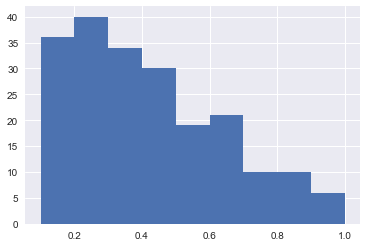

In [25]:
plt.hist(array_error, bins=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

In [26]:
array_error10 = array_error[(array_error <= 0.33)]

In [27]:
len(array_error10)

160

In [28]:
165/337

0.4896142433234421

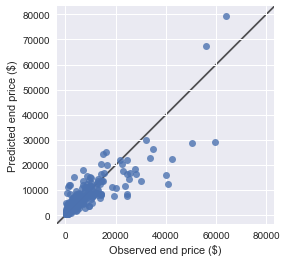

In [29]:
fig1 = sns.regplot(x=Y_test, y=predicted_test, fit_reg=False)
fig1.set(xlabel='Observed end price ($)', ylabel='Predicted end price ($)')

lims = [
    np.min([fig1.get_xlim(), fig1.get_ylim()]),  # min of both axes
    np.max([fig1.get_xlim(), fig1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
fig1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
fig1.set_aspect('equal')
fig1.set_xlim(lims)
fig1.set_ylim(lims)
# plt.savefig('validation.pdf', bbox_inches='tight')
plt.show()


(0, 25000)

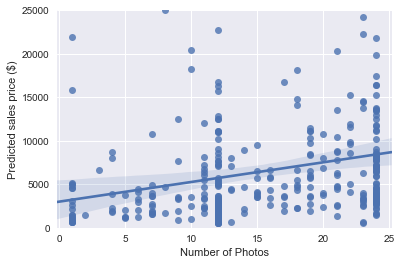

In [30]:
fig2 = sns.regplot(x=X_test['photo number'], y=predicted_test, fit_reg=True)
fig2.set(xlabel='Number of Photos', ylabel='Predicted sales price ($)')
plt.ylim(0, 25000)
# plt.savefig('price_photo_cor.pdf', bbox_inches='tight')

In [31]:
photo_numbers = X_test['photo number'].tolist()
photo_numbers

[12,
 24,
 12,
 6,
 22,
 24,
 22,
 19,
 11,
 12,
 19,
 12,
 17,
 24,
 1,
 12,
 11,
 12,
 12,
 24,
 4,
 16,
 12,
 12,
 18,
 15,
 24,
 1,
 19,
 7,
 12,
 24,
 11,
 12,
 23,
 7,
 7,
 24,
 12,
 24,
 24,
 12,
 24,
 12,
 12,
 7,
 10,
 12,
 24,
 11,
 18,
 8,
 10,
 12,
 24,
 19,
 18,
 12,
 11,
 20,
 12,
 12,
 12,
 5,
 12,
 22,
 12,
 23,
 24,
 24,
 10,
 24,
 12,
 24,
 12,
 14,
 21,
 1,
 20,
 21,
 12,
 1,
 12,
 24,
 24,
 12,
 23,
 3,
 6,
 24,
 7,
 7,
 12,
 12,
 12,
 18,
 16,
 12,
 24,
 12,
 24,
 24,
 12,
 24,
 24,
 15,
 23,
 23,
 19,
 18,
 24,
 14,
 24,
 19,
 5,
 17,
 20,
 16,
 12,
 11,
 9,
 11,
 1,
 21,
 24,
 12,
 23,
 24,
 9,
 1,
 1,
 24,
 24,
 24,
 18,
 24,
 18,
 7,
 17,
 24,
 12,
 16,
 11,
 1,
 11,
 12,
 12,
 24,
 12,
 24,
 24,
 1,
 15,
 7,
 24,
 5,
 12,
 21,
 23,
 12,
 10,
 1,
 1,
 12,
 17,
 11,
 12,
 11,
 18,
 14,
 23,
 21,
 11,
 12,
 1,
 12,
 4,
 24,
 12,
 23,
 12,
 12,
 24,
 19,
 24,
 12,
 9,
 1,
 15,
 16,
 2,
 12,
 16,
 9,
 12,
 1,
 12,
 24,
 24,
 24,
 12,
 21,
 24,
 8,
 22,
 23,
 12,
 1

In [32]:
predicted_prices = predicted_test.tolist()

In [33]:
mean_prices_df = pd.DataFrame({
    'photo number': photo_numbers,
     'predicted price': predicted_prices
    })

In [34]:
photos_nums2 = list(range(25))
mean_prices = []

for num in photos_nums2:
    photo_df = mean_prices_df[mean_prices_df['photo number'] == num]
    mean_prices.append(photo_df['predicted price'].mean())
    
# photo_df = mean_prices_df[mean_prices_df['photo number'] == 3]
# photo_df['predicted price'].mean()

In [35]:
mean_prices = pd.Series(mean_prices).fillna(0).tolist()

In [36]:
mean_prices_se = pd.Series(mean_prices)
photos_nums2_se = pd.Series(photos_nums2)

[Text(0,0.5,'Mean predicted sales price ($)'), Text(0.5,0,'Number of Photos')]

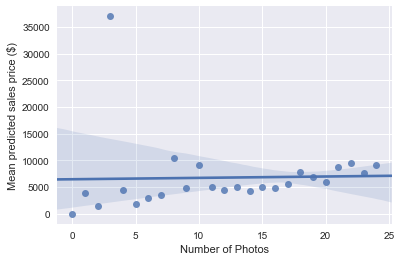

In [37]:
fig2b = sns.regplot(x=photos_nums2_se, y=mean_prices_se, fit_reg=True)
fig2b.set(xlabel='Number of Photos', ylabel='Mean predicted sales price ($)')
# plt.savefig('mean_price_photo_cor.pdf', bbox_inches='tight')

In [38]:
slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = stats.linregress(x=photos_nums2_se,y=mean_prices_se)

(slope_1, std_err_1, r_value_1)

(25.684534128764106, 193.2834106301321, 0.027697880741491029)

In [39]:
(slope_1/np.mean(Y_test))*100

0.39593222615422408

In [40]:
# model_gauss = lambda x, A, x0, sigma, offset:  offset+A*np.exp(-((x-x0)/sigma)**2)
# popt, pcov = curve_fit(model_gauss, X_test['fm'].values, 
#                               predicted_test, p0=[10000,1000,2,100])

In [41]:
# x = np.linspace(X_test['fm'].values.min(),X_test['fm'].values.max(),250)
# plt.plot(x,model_gauss(x,*popt), label="fit")

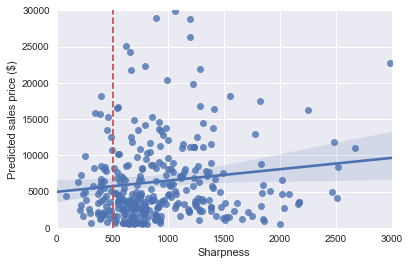

In [43]:
fig3 = sns.regplot(x=X_test['fm'], y=predicted_test, fit_reg=True)
fig3.set(xlabel='Sharpness', ylabel='Predicted sales price ($)')
plt.axvline(x=500, color='r', linestyle='--')
plt.ylim(0, 30000)
plt.xlim(0, 3000)
# plt.savefig('pred_price_sharpness_cor.pdf', bbox_inches='tight')
# fm = 500 is the 'blur' threshold

In [44]:
X_test['fm'].mean()

958.0218303846722

In [45]:
slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(x=X_test['fm'],y=predicted_test)

(slope_2, std_err_2, r_value_2)

(1.5612655868519751, 0.69948998636461268, 0.1210507319120962)

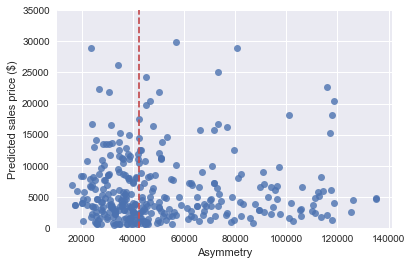

In [48]:
fig3 = sns.regplot(x=X_test['m norm vert'], y=predicted_test, fit_reg=False)
fig3.set(xlabel='Asymmetry', ylabel='Predicted sales price ($)')
plt.axvline(x=X_test['m norm vert'].median(), color='r', linestyle='--')
plt.ylim(0, 35000)
plt.savefig('pred_price_symmetry_cor.pdf', bbox_inches='tight')
# 30000 is the symmetry threshold

In [111]:
X_test['m norm vert'].median()

42816.68312757202

[Text(0,0.5,'Predicted sales price ($)'), Text(0.5,0,'blur')]

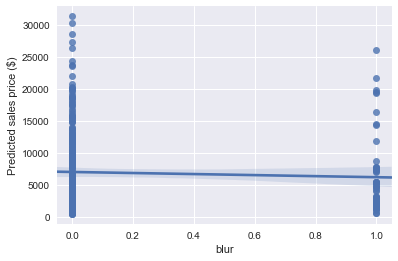

In [26]:
fig4 = sns.regplot(x=X_test['blur'], y=predicted_test, fit_reg=True)
fig4.set(xlabel='blur', ylabel='Predicted sales price ($)')
# plt.ylim(0, 25000)

In [99]:
blur_test = X_test['blur'].tolist()

In [100]:
pred_price = predicted_test.tolist()

In [101]:
blur_df = pd.DataFrame(
    {'blur': blur_test,
     'predicted price': pred_price
    })

In [102]:
blurry_df = blur_df[blur_df['blur'] > 0]

In [105]:
blurry_df['predicted price'].mean()

7322.660388474574

In [106]:
no_blurry_df = blur_df[blur_df['blur'] < 1]
no_blurry_df['predicted price'].mean()

7365.992933812951

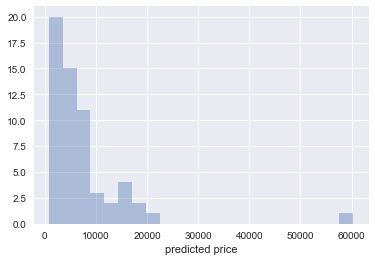

In [107]:
sns.distplot(blurry_df['predicted price'], kde=False)

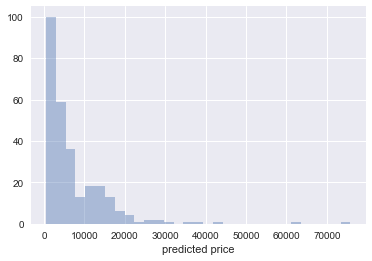

In [108]:
sns.distplot(no_blurry_df['predicted price'], kde=False)

In [35]:
# filename = '/Users/donalddressen/Documents/insight_project/lca/finalized_model_3.sav'
# pickle.dump(rf, open(filename, 'wb'))

In [71]:
list(range(1,2))

[1]